# Tutorial 2: Machine collective variables with `mlcolvar`

<center><img src="../figures/logo_name_black_big.svg" width="600" /></center>


In this tutorial we will provide an example of how to use the `mlcolvar` library for is main purpose: training machine learning collective variables!

We will use the `DeepTDA` method to train a classifier-like CV from information limited to the metastable basins. This will help us introducing the general workflow of the library, which is the same also for the other Deep-CVs implemented there.

We cannot cover all the possibilities today. However, with Luigi and Andrea we prepared a vast documentation for the library in whihc yuo can find MANY tutorials and you can also get in touch with me the next days or with us on GitHub ;)

TODO: Add links to the library


# Import modules

In [3]:
# General libs
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# mlcolvar modules we already know
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.plot import paletteFessa
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep
from mlcolvar.utils.fes import compute_fes

# useful stuff
mfep = muller_brown_mfep()

# Outline

Typically, the process of constructing a data-driven CV requires the following ingredients:
1) A dataset (with input features and possibly targets or labels) 
2) A model (e.g. a neural network) and an objective function.

Once we have them, we can combine them and optimize the CV (via a trainer object).

Finally, we can export the CV in order to be deployed in PLUMED.

# Load data and create dataset

We will use the unbiased data in the metastable states we produced in the previous notebook

In [10]:
# utils specific to create datasets for training
from mlcolvar.utils.io import create_dataset_from_files
# handling of lightning datamodule
from mlcolvar.data import DictModule

# we can also specify the folder or teh common part of the paths
folder = "../1_enhanced_sampling/simulations/unbiased_sims/"
file_names = ["A/COLVAR",
              "B/COLVAR"]

# create a torch dataset and a pandas dataframe with our data
dataset, df = create_dataset_from_files(file_names=file_names,
                                        folder=folder,
                                        return_dataframe=True, 
                                        filter_args={'regex':'p.x|p.y'}, 
                                        stop=8000, 
                                        stride=4) # we can train faster with fewer points, here it doesn't change much

# create datamodule for training
datamodule = DictModule(dataset,lengths=[0.8,0.2])

# check our datamodule
datamodule

Class 0 dataframe shape:  (2000, 17)
Class 1 dataframe shape:  (2000, 17)

 - Loaded dataframe (4000, 17): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels']
 - Descriptors (4000, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [4000, 2], "labels": [4000] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

We can visualize the dataset

Text(0, 0.5, 'p.y')

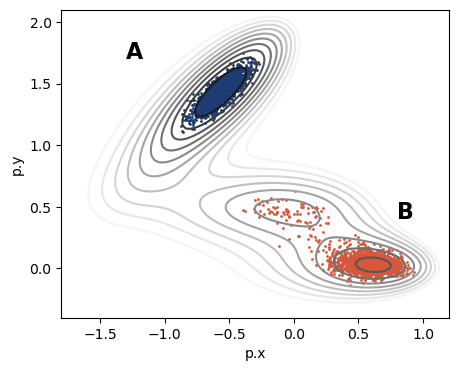

In [15]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
for i,s in enumerate(['A', 'B']):
    temp = df[df['labels'] == i]
    ax.scatter(temp['p.x'],temp['p.y'], color=paletteFessa[0 + 6*i], s=1)

# draw state labels
ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# Initialize and train model

### Initialize

In [16]:
# Import DeepTDA class
from mlcolvar.cvs import DeepTDA

# Parameters
n_states = 2                # number of states
n_cvs = 1                   # Dimension of CV space
target_centers = [-5, 5]    # Centers of target Gaussians
target_sigmas = [0.2, 0.2]  # Width of target Gaussians
nn_layers = [2,12,12,1]     # Architecture of NN

# options for the model, the CV classes are organized in blocks, e.g. 'nn'. The options are passed as **kwargs to them
options = {'nn' : {'activation' : 'shifted_softplus'}}

# Initialize DeepTDA model
model = DeepTDA(n_states=n_states, 
                n_cvs=1,
                target_centers=target_centers, 
                target_sigmas=target_sigmas, 
                layers=nn_layers)

### Train

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [1, 2]   | [1, 2]   
2 | nn      | FeedForward   | 205    | [1, 2]   | [1, 1]   
-----------------------------------------------------------------
205       Trainable params
0         Non-trainable params
205       Total params
0.001     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/CSI_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 50.08it/s, v_num=10] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 46.96it/s, v_num=10]


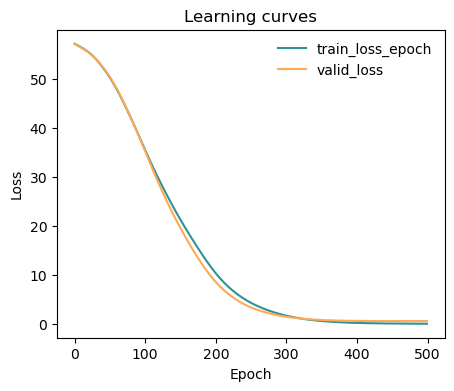

In [17]:
import lightning
# utils for metrics recording
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

# define callbacks, are called during the training. Another example is earystopping.
metrics = MetricsCallback()

# define trainer
trainer = lightning.Trainer(callbacks=[metrics],
                            max_epochs=500, 
                            logger=None,
                            enable_checkpointing=False)

# fit model on our datamodule
trainer.fit( model, datamodule )

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss_epoch','valid_loss'],
                  colors=['fessa1','fessa5'],
                  yscale='linear')

### Analyze CV space

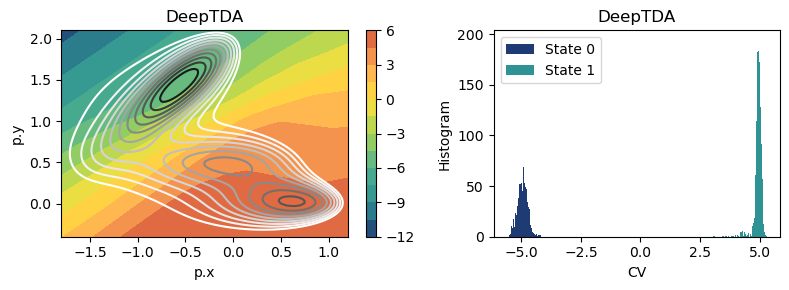

In [37]:
fig,axs = plt.subplots( 1, 2, figsize=(8,3), gridspec_kw={'width_ratios' : [5,4]} )

# plot CV isolines
ax = axs[0]
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('DeepTDA')
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# plot histogram of training data along CV
ax = axs[1]
X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}', color=paletteFessa[i])

ax.set_xlabel('CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.tight_layout()
plt.show()

### Export frozen CV model to be used in PLUMED

In [52]:
model.to_torchscript('model_tda.pt', method='trace')

DeepTDA(
  original_name=DeepTDA
  (loss_fn): TDALoss(original_name=TDALoss)
  (norm_in): Normalization(original_name=Normalization)
  (nn): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): ReLU(original_name=ReLU)
      (2): Linear(original_name=Linear)
      (3): ReLU(original_name=ReLU)
      (4): Linear(original_name=Linear)
    )
  )
)

# Run simulations

In [54]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_metad_tda_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_tda_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_tda_sims.sh', returncode=0)

No protocol specified
No protocol specified


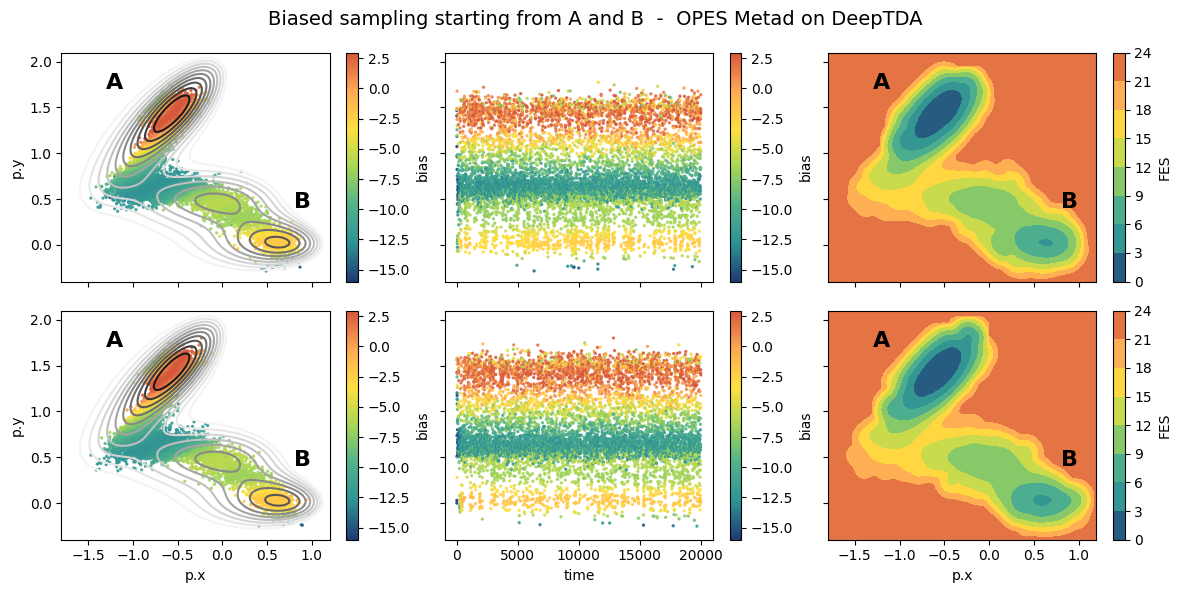

In [4]:
# load data
sampling = load_dataframe([f'simulations/opes_metad_tda/A/COLVAR', f'simulations/opes_metad_tda/B/COLVAR'], start=0)

# plot data, we use the same function of the previous tutorial
def plot_simulations_biased(title, data, kbt, bias_name):
    # create plot
    fig, axs = plt.subplots(2,3,figsize=(12,6))
    # make title
    fig.suptitle(f"Biased sampling starting from A and B  -  {title}", fontsize=14)
    
    # we plot the data from obtained starting from A and B
    for i,s in enumerate(['A', 'B']):
        # scatter plot in x,y space
        ax = axs[i, 0]
        plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
        temp = data[data['walker'] == i]
        cp = ax.scatter(temp['p.x'], temp['p.y'], c=temp[bias_name], s=2, alpha=0.8, cmap='fessa')
        cbar = plt.colorbar(cp, ax=ax, label = 'bias')
        # make it nicer
        cbar.solids.set(alpha=1)
        ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
        ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
        ax.set_ylabel('p.y')
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('p.x')


        # time series of y coordinates
        ax = axs[i, 1]
        
        cp = ax.scatter(temp['time'], temp['p.y'], c=temp[bias_name], s=2, alpha=0.8, cmap='fessa')
        cbar = plt.colorbar(cp, ax=ax, label = 'bias')
        # make it nicer
        cbar.solids.set(alpha=1)
        ax.set_ylim((-0.4, 2.1))
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('time')
            
        
        # plot free enery surface estimate
        ax = axs[i, 2]
        weights = np.exp(1/kbt*temp[bias_name].values)
        fes,bins,_,_ = compute_fes(temp[['p.x', 'p.y']].values, 
                                   kbt=kbt, 
                                   weights=weights, 
                                   plot=True, 
                                   num_samples=200, 
                                   eps=1e-8, 
                                   bandwidth=0.05, 
                                   plot_max_fes=24, 
                                   ax=ax, 
                                   bounds=((-1.8, 1.2), (-0.4, 2.1)))
        # make it nicer
        ax.text(-1.3, 1.7, 'A', fontsize=16, fontweight='bold')
        ax.text(0.8, 0.4, 'B', fontsize=16, fontweight='bold')
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        if i==0: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('p.x')

    plt.tight_layout()
    plt.show()   

plot_simulations_biased(title='OPES Metad on DeepTDA', data=sampling, kbt=1, bias_name='opes.bias')